# **Single-Lead ECG Arrhythmia Classification**

## **a. Summary, At a Glance**


*   **Task:** Arrhythmia Classification, 5 classes
*   **Dataset:** MIT-BIH ECG dataset, Dataset website: [Here](https://physionet.org/content/mitdb/1.0.0/)
*   **Model:** CNN_LSTM with Attention
*   **Performance:** 98.5% Validation Accuracy




## **b. Information about Dataset:**


The dataset can be downloaded from the original [website](https://physionet.org/content/mitdb/1.0.0/) or by clicking the [link](https://physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip) directly. The overall information about the dataset is given [here](https://archive.physionet.org/physiobank/database/html/mitdbdir/intro.htm).
1. The MIT-BIH dataset contains **48 readings**.
2. Number of **patients = 47** (25 Men, 22 Women). Only 1 patient has 2 readings. Rest 1 readings/patients.
3. Each reading contains a. ECG signals b. Annotations
4. ECG signals length = **30 Minutes** (or slightly over). Sampling Frequency = **360 Hz**. 
5. Each reading contains **2 Lead ECG** signals that are Modified Limb Lead II and Modified Lead V1 (Occationally V2, V5, V4 just only once). Simply, Two Leads: **MLII, V1**.
6. Annotation is given for each beat. Although 20 types of beats are annotated in dataset. We consider only **15 types** of beats grouped in **5 classes** followed by the recommendation of **AAMI**.
* N - Normal
* S - Supraventricular premature beat
* V - Premature ventricular contraction
* F - Fusion of ventricular and normal beat
* Q - Unclassifiable / Unknown beat 

### **Additional Dataset Information:**
The source of the ECGs included in the MIT-BIH Arrhythmia Database is a set of over **4000 long-term Holter recordings** that were obtained by the **Beth Israel Hospital** Arrhythmia Laboratory between **1975 and 1979**. Approximately **60%** of these recordings were obtained from **inpatients**. The subjects were 25 men aged 32 to 89 years, and 22 women aged 23 to 89 years

# **Main Parts of the Study:** 

1.   **Part A: Installing Packages and Basic Visualization of ECG**
2.   **Part B: Denoising, R-Peak Detection, Segmentation**
3.   **Part C: Dataset Loading**
4.   **Part D: Train-Test Splitting and Class Balancing**
5.   **Part E: Model Building and Training**
6.   **Part F: Results**

# **Part A: Installing Packages and Basic Visualization of ECG**

## **A1: Installing Packages**

In [57]:
!pip install wfdb PyWavelets seaborn numpy tensorflow matplotlib scikit-learn pandas imbalanced-learn


## Importing Dependencies

In [1]:
# Importing packages
import os
import datetime
import wfdb
import pywt
import seaborn
import numpy as np
from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import seaborn as sns

## **A2: Basic Visualization of ECG**
Basic code for loading (reading), plotting and playing with ECG signals

### **a. Getting Recordings' IDs**
The ECG recordings are named after Patients' IDs (from 100 to 234), sorted but not consecutive. Total 48 recordings. 

In [2]:
RECORDS = "records"
ANNOTATIONS = "annotations" 

In [3]:
patient_ids = pd.read_csv(RECORDS, header=None).to_numpy().reshape(-1)
print(patient_ids)

[100 101 102 103 104 105 106 107 108 109 111 112 113 114 115 116 117 118
 119 121 122 123 124 200 201 202 203 205 207 208 209 210 212 213 214 215
 217 219 220 221 222 223 228 230 231 232 233 234]


### **b. 1 Patient ECG loading and plotting**
Extracting 2 leads ECG signals of a patient (for example: 100), and saving in two lists. 

In [4]:
DATA_ROOT = "mit-bih-arrhythmia-database-1.0.0\mit-bih-arrhythmia-database-1.0.0"

In [5]:
# Extracting just 1 patient ECG signal and info
lead0 = {}  # wrist lead
lead1 = {}  # chest lead
signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(100))) # wfdb.io.rdsamp used to read the dataset of MIT, str (100) is the patient number
print(signals.shape)
print(info) 
lead0[100] = signals[:, 0]
lead1[100] = signals[:, 1]

(650000, 2)
{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}


<class 'numpy.ndarray'>
(650000,)
{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}


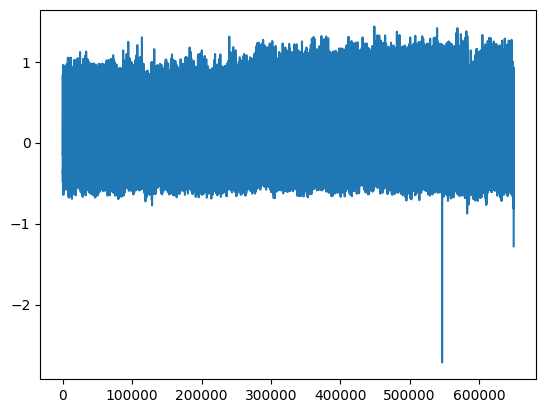

In [6]:
# Visualization of 1 patients signal and info
print(type(lead0[100]))
print(lead0[100].shape)
plt.plot(lead0[100])
print(info)



The **MIT-BIH Arrhythmia Database** records ECG signals at a sampling rate of **360 Hz**.  
This means that **each second** of ECG data contains **360 samples**.

By selecting the first **3000 samples**:

3000 samples / 360  = 8.33  seconds

This means the plot will visualize the **first 8.33 seconds** of the ECG signal.


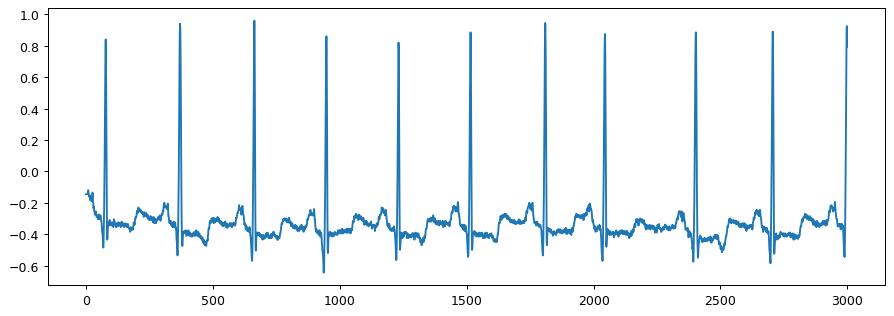

In [7]:

a = lead0[100][0: 3000]
plt.figure(figsize=(12, 4), dpi=90)
plt.plot(a)

### **c. All patients' ECG loading**

In [8]:
# Loading all patients ECG SIGNALs using for loop
def get_ecg_signals(patient_ids):
    lead0 = {}
    lead1 = {}
    for id_ in patient_ids:
        signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(id_)))
        lead0[id_] = signals[:, 0]
        lead1[id_] = signals[:, 1]
        print(f'Signal of patient {id_} extracted')
    return lead0, lead1

In [9]:
# Loading all patient ECG INFORMATION 
def get_ecg_info(patient_ids):
    _, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(patient_ids)))
    resolution = 2**11  # Precision of the data
    info["resolution"] = 2**11
    return info

In [10]:
lead0, lead1 = get_ecg_signals(patient_ids)

Signal of patient 100 extracted
Signal of patient 101 extracted
Signal of patient 102 extracted
Signal of patient 103 extracted
Signal of patient 104 extracted
Signal of patient 105 extracted
Signal of patient 106 extracted
Signal of patient 107 extracted
Signal of patient 108 extracted
Signal of patient 109 extracted
Signal of patient 111 extracted
Signal of patient 112 extracted
Signal of patient 113 extracted
Signal of patient 114 extracted
Signal of patient 115 extracted
Signal of patient 116 extracted
Signal of patient 117 extracted
Signal of patient 118 extracted
Signal of patient 119 extracted
Signal of patient 121 extracted
Signal of patient 122 extracted
Signal of patient 123 extracted
Signal of patient 124 extracted
Signal of patient 200 extracted
Signal of patient 201 extracted
Signal of patient 202 extracted
Signal of patient 203 extracted
Signal of patient 205 extracted
Signal of patient 207 extracted
Signal of patient 208 extracted
Signal of patient 209 extracted
Signal o

Text(0, 0.5, 'Amplitude (mV)')

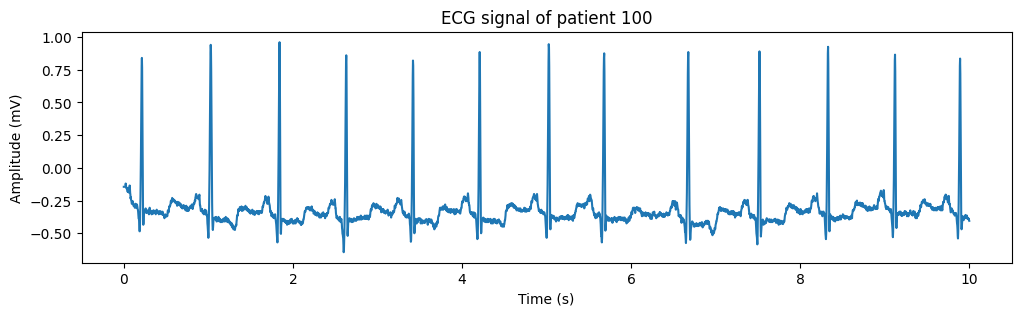

In [11]:
# Plot any patient signal from any time frame
patient_id = 100 # can change
starting_time = 0 # can change
ending_time = 10 # can change

# Scaling
starting_signal_point = starting_time*360
ending_signal_point = ending_time*360 # As sampling frequency is 360 Hz
x = np.arange(starting_time, ending_time, 1/360)
signal = lead0[patient_id][starting_signal_point: ending_signal_point]

plt.figure(figsize=(12, 3), dpi=100)
plt.plot(x, signal)
plt.title(f'ECG signal of patient {patient_id}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')

In [12]:
# ECG info of any patient
ecg_info = get_ecg_info(patient_ids[0])
ecg_info

{'fs': 360,
 'sig_len': 650000,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['MLII', 'V5'],
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'resolution': 2048}

# **Part B: Denoising, R-Peak Detection, Segmentation** 

### **B1: Denoising**
Noise removing by using Discrete Wavelet Transform (DCT)

In [13]:
# User defined fucntion for DWT and reconstruction
def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

In [14]:
project_path = "mit-bih-arrhythmia-database-1.0.0\mit-bih-arrhythmia-database-1.0.0/"

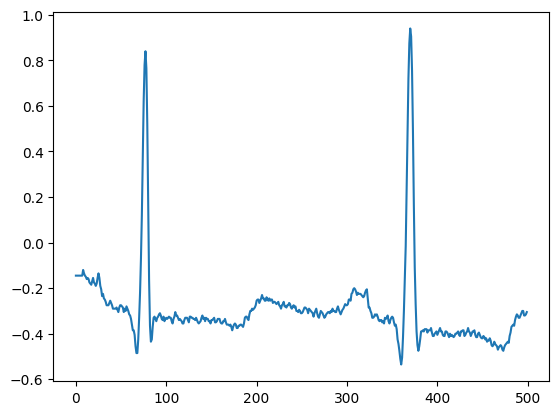

In [15]:
# Ploting a signal before denoising
record = wfdb.rdrecord(project_path + '100', channel_names=['MLII'])
data = record.p_signal.flatten()
plt.plot(data[0:500])

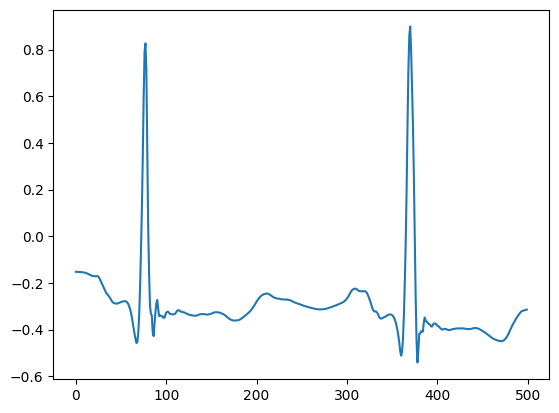

In [16]:
# Same signal after denoising
rdata = denoise(data)
plt.plot(rdata[0:500])

### **B2: R-Peak Detection**
R-peak is annotated in MIT-BIH dataset. Just need to read the file.

In [17]:
# For exmaple, we extract '100' recording annotation
annotation = wfdb.rdann(project_path + '100', 'atr')
Rlocation = annotation.sample
print(Rlocation)
Rclass = annotation.symbol
print(Rclass)

[    18     77    370 ... 649484 649734 649991]
['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '

In [18]:
len(annotation.symbol)

2274

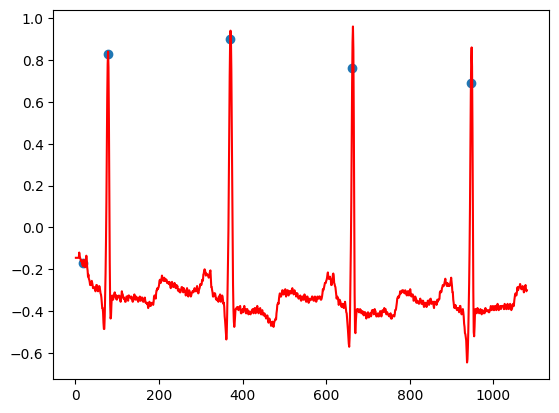

In [19]:
# R-peak ploting
x = np.arange(1, 1081)

n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])

plt.plot(x, data[0:1080], color='red')
plt.scatter(r_peak_x, r_peak_y)

### **B3: Segmentation**
Each ECG signal is segmented by using a window **length of 300**. From R-peak location, **99** samples taken from **left** and **201** samples from **right**. Thus a complete **heartbeat** is found.

(300,)
(300,)
(300,)


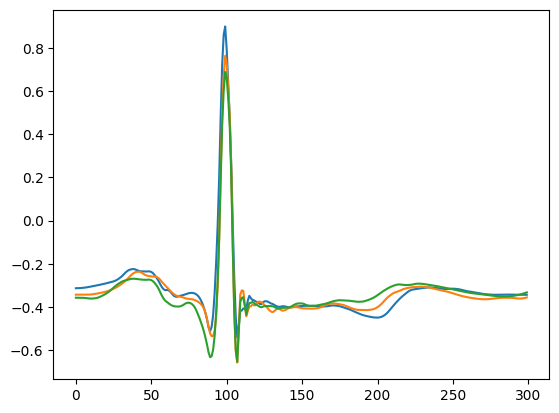

In [20]:
# Plotting 3 heartbeats
k = np.arange(2, 5)
for i in k:
  x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
  plt.plot(x_train)
  print(x_train.shape)
plt.show()

### **B4: Complete Preprocessing Figures**
The complete preprocessing including denosinsing, R-peak location detection and segmentation is expected to view in a single figure. 

In [21]:
r_peak_xx = Rlocation[0], Rlocation[1], Rlocation[2], Rlocation[3]
r_peak_yy = rdata[Rlocation[0]], rdata[Rlocation[1]], rdata[Rlocation[2]], rdata[Rlocation[3]]

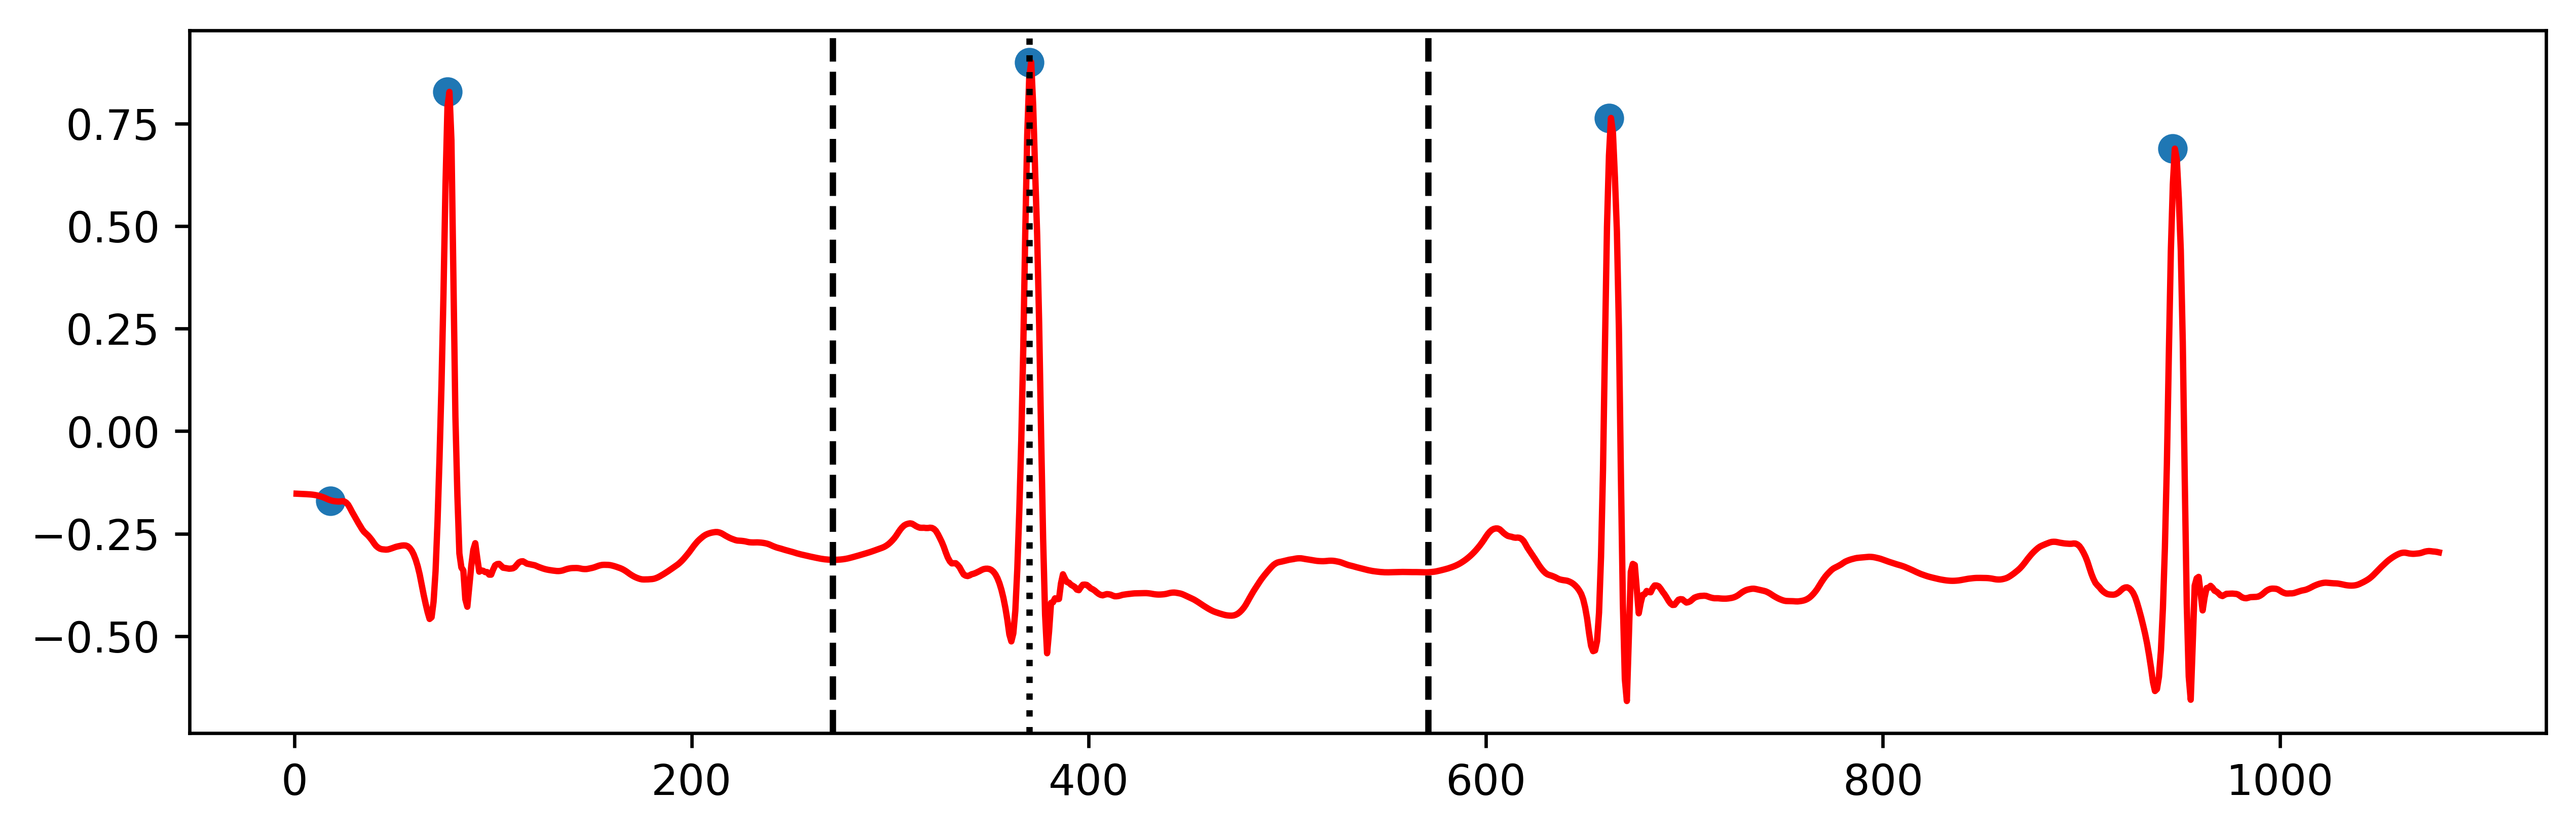

In [22]:
# Plotting R-peaks and segmentation lines
fig = plt.figure(figsize=(10,3), dpi=600)
n_peak = 5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])
x = np.arange(1, 1081)
plt.plot(x, rdata[0: 1080], color='red')
plt.scatter(r_peak_x, r_peak_y)

# line plotting
plt.axvline(x = Rlocation[2], color = 'k', linestyle = ':') 
plt.axvline(x = Rlocation[2]-99, color = 'k', linestyle = '--') 
plt.axvline(x = Rlocation[2]+201, color = 'k', linestyle = '--') 

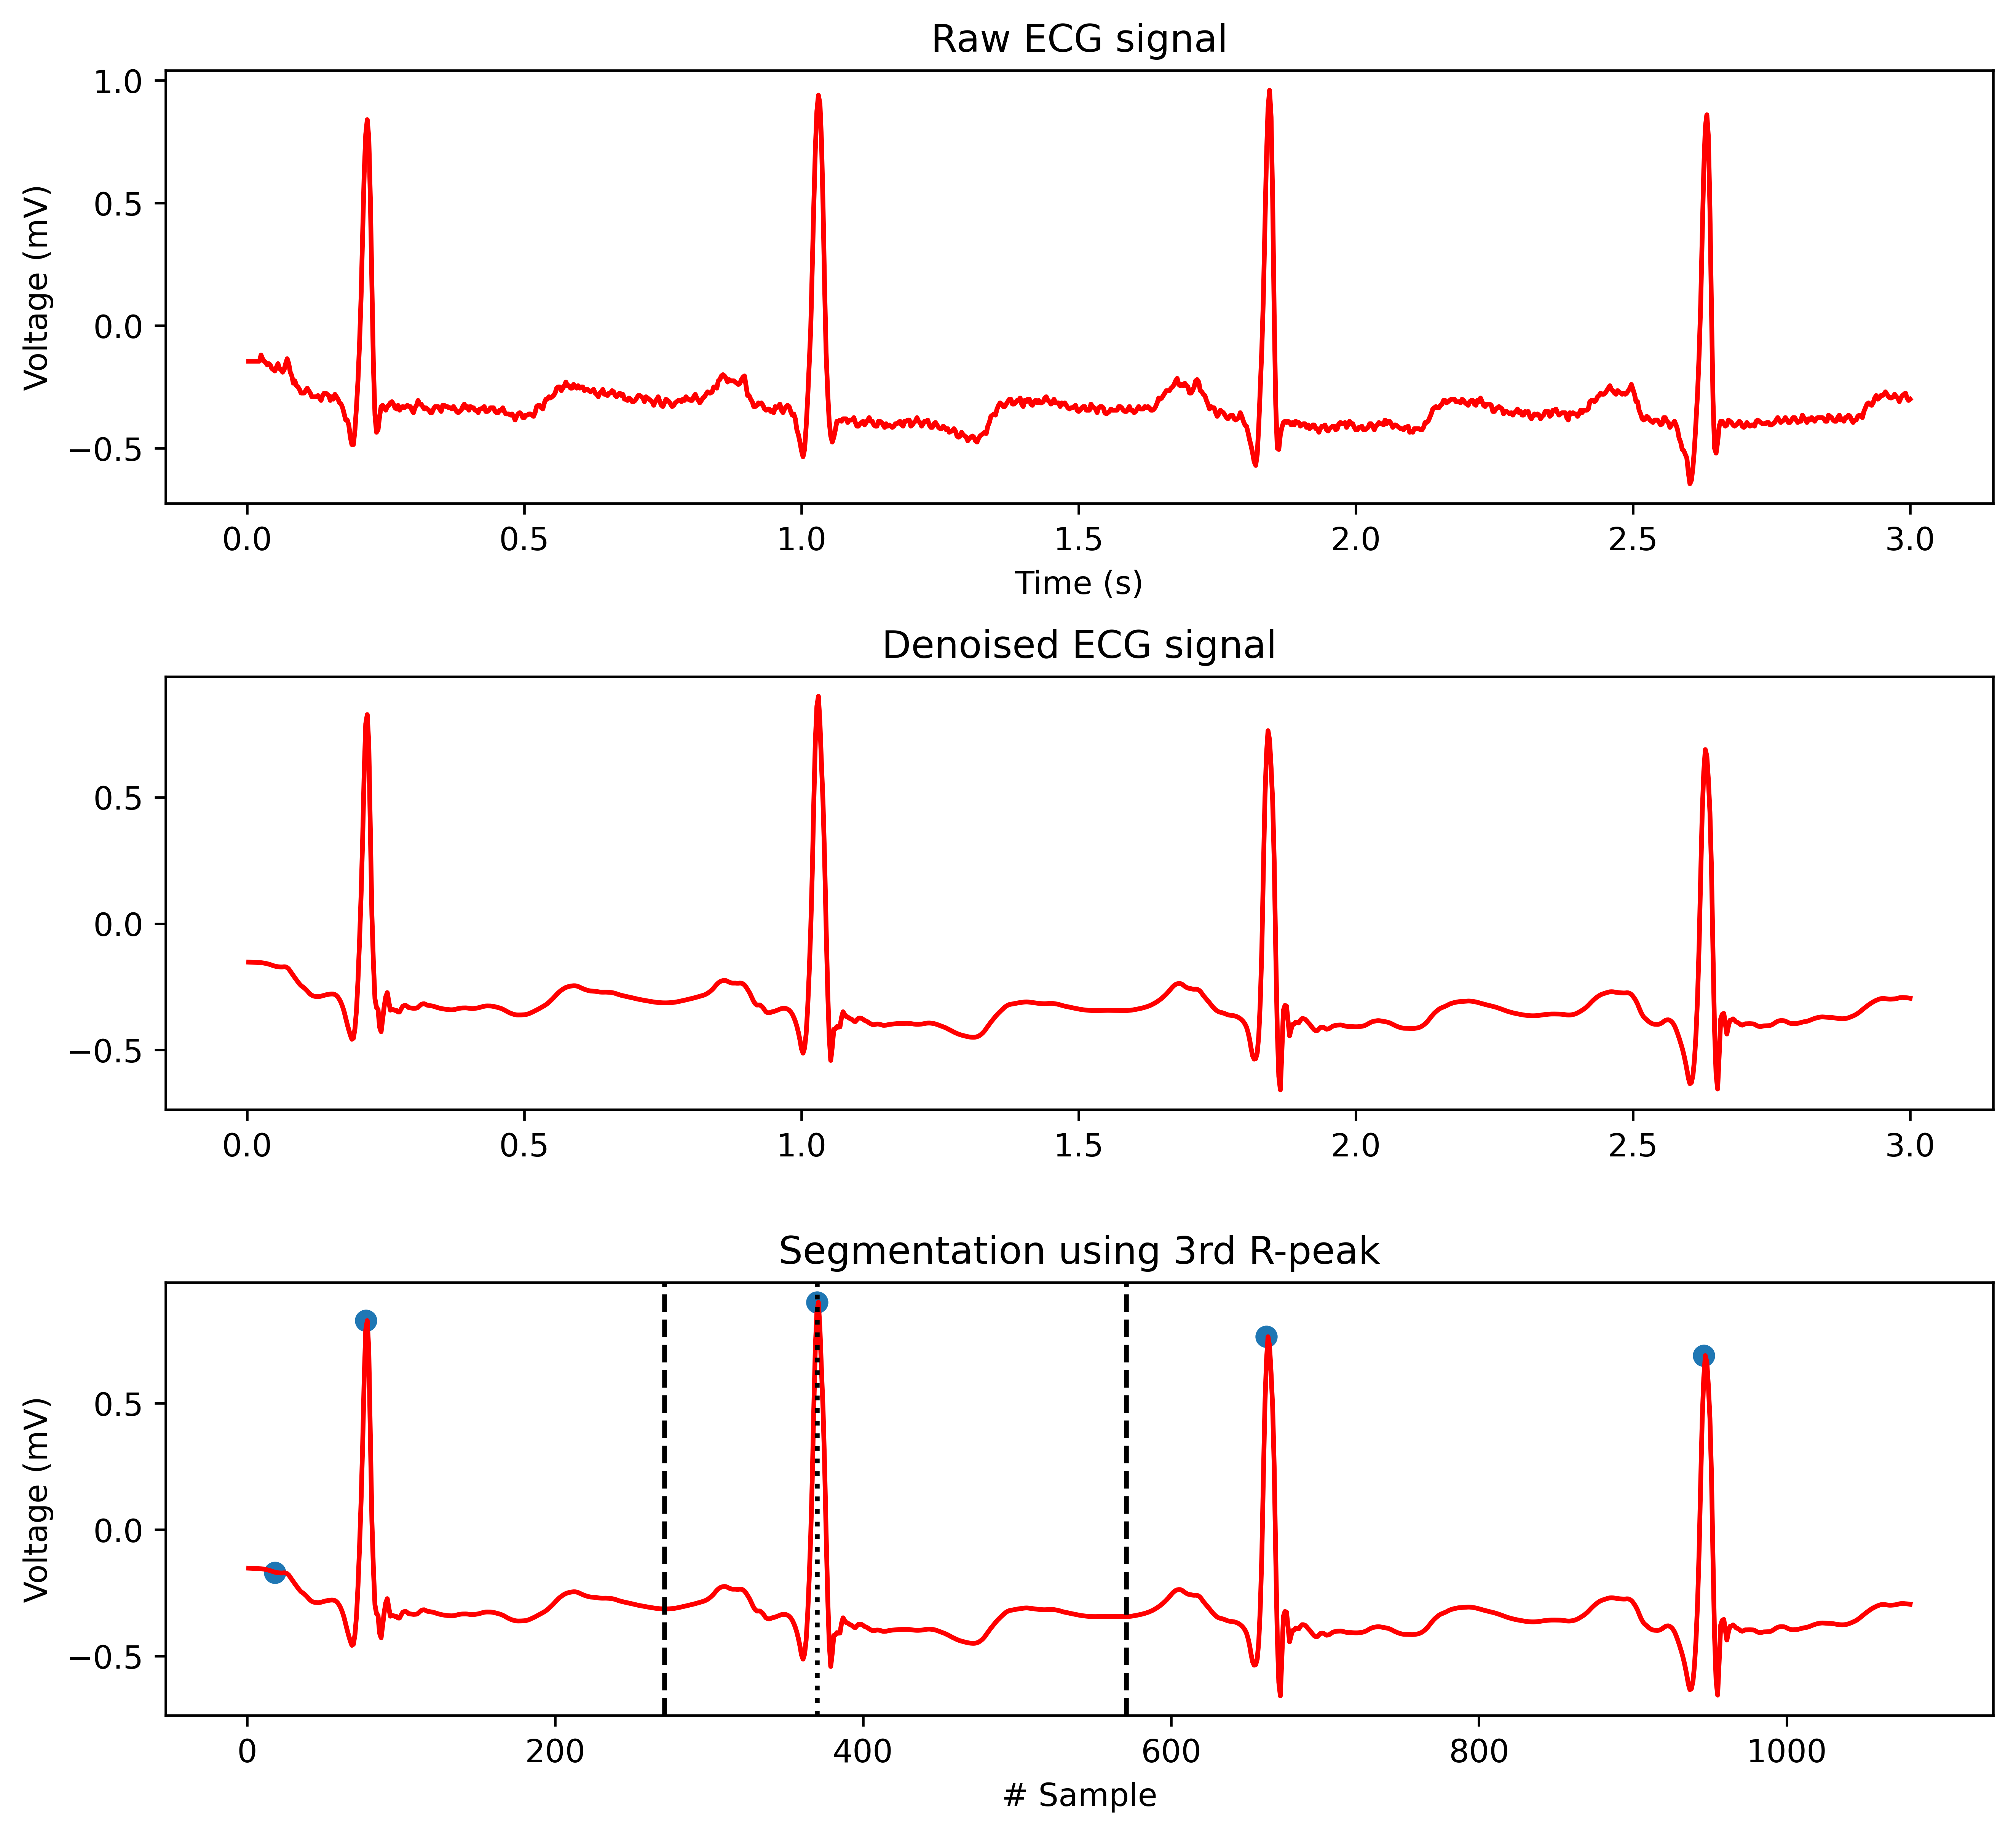

In [23]:
# Plot together raw, denoised and segmted signal
fig = plt.figure(figsize=(10,9), dpi=600)
x = np.arange(1, 1081)

# Raw signal plotting
plt.subplot(3, 1, 1)
plt.plot(x/360, data[0:1080], color='red')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Raw ECG signal')

# Denoised signal plotting
plt.subplot(3, 1, 2)
plt.plot(x/360, rdata[0:1080], color='red')
plt.title('Denoised ECG signal')

# Segmentation visualization using two border lines
plt.subplot(3, 1, 3)
n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])
x = np.arange(1, 1081)
plt.plot(x, rdata[0: 1080], color='red')
plt.scatter(r_peak_x, r_peak_y)
# line plotting
plt.axvline(x = Rlocation[2], color = 'k', linestyle = ':') # 3rd r-peak
plt.axvline(x = Rlocation[2]-99, color = 'k', linestyle = '--') 
plt.axvline(x = Rlocation[2]+201, color = 'k', linestyle = '--') 

plt.xlabel('# Sample')
plt.ylabel('Voltage (mV)')
plt.title('Segmentation using 3rd R-peak')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

figure_path = "ECG_Analysis/"
fig.savefig(figure_path+ 'Denoised and segmented ECG.png')

# **Part C: Dataset Loading**

## **C1: Loading whole data**

In [24]:
# Read ECG signals and corresponding label
def getDataSet(number, X_data, Y_data):
    
    # Considering 15 types ECG heartbeats that are later grouped in 5 classes
    ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q'] 

    # Reading Channel names
    _, info = wfdb.io.rdsamp(osj(project_path, number))
    channels = info['sig_name']
    channel1, channel2 = channels[0], channels[1]
    print(channel1, channel2)


    # Read ECG data records
    print("reading " + number+ " ECG data...")
    record = wfdb.rdrecord(project_path + number, channel_names=[channel1])
    data = record.p_signal.flatten()
    rdata = denoise(data=data)

    # Obtain the position and corresponding label of the R wave in the ECG data record
    annotation = wfdb.rdann(project_path + number, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol

    # Unstable data before and after removal
    start = 2  # if it creates problem then except will do the job
    end = 3  
    i = start
    j = len(annotation.symbol) - end

    # Making labels, Y_data Convert NSVFQ in order to 0123456...14
    while i < j:
        try:
            beat_type = Rclass[i]
            lable = ecgClassSet.index(beat_type)  # when beat is like '+' or other it will go on except loop
            x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 1
        except ValueError:
            # print(f' when i = {i}, beat type is out of our choise. For example +, [, ! or other')
            i += 1
    return X_data, Y_data

In [25]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', 
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', 
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', 
                 '222', '223', '228', '230', '231', '232', '233', '234'] # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)

    # dataset and its label set
    X = train_ds[:, :300]
    Y = train_ds[:, 300]
    return X, Y

In [26]:
# Input X and Output Y data loading
X, Y = loadData()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

In [27]:
# Counting the number of each type of heartbeats
Y_list = list(Y)
Counter(Y_list)

Counter({0.0: 74920,
         1.0: 8063,
         2.0: 7244,
         9.0: 7123,
         12.0: 7012,
         5.0: 2540,
         13.0: 982,
         11.0: 802,
         4.0: 229,
         6.0: 150,
         10.0: 106,
         7.0: 83,
         14.0: 33,
         3.0: 16,
         8.0: 2})

## **C2: Ploting 15 Different Heartbeats**

In [28]:
# making pandas dataframe
df_X = pd.DataFrame(X)
df_Y = pd.DataFrame(Y)

In [29]:
# changing the name from 0 to 300
df_Y.rename(columns = {0:300}, inplace = True)
# join X and Y
df = pd.concat([df_X, df_Y], axis=1)

In [30]:
def Plot_Random_Beat(type, num):

  ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', 'slash', 'f', 'Q']
  
  ecgClassName = ['Normal (N)', 'Left bundle br. bl. (L)', 'Right bundle br. bl. (R)', 
                  'Atrial escape (e)', 'Nodal jun. esc. (j)', 'Atrial premature (A)', 
                  'Aberrated atrial prem. (a)', 'Nodal jun. pre. (J)', 
                  'Supraventricular prem. (S)', 'Premature ventr. (V)', 
                  'Ventricular escape (E)', 'Fusion of ve. & no. (F)', 
                  'Paced (/)', 'Fusion of pa. & no. (f)', 
                  'Unclassifiable(Q)'] 

  # getting only a specific class ECG signal
  df_0 = df.loc[df[300]==type]  # For normanl class: 0, shape is 74920,301
  df_0 = df_0.drop(columns=[300]) # changing the shape to 74920,300

  # selecting some random row to plot
  if num<=df_0.shape[0]:
    np.random.seed(234)
    random_beat_number = np.random.randint(df_0.shape[0], size=(num))
    random_beat_number = list(random_beat_number)
  else: # Needed for Supraventricular Premature Beat (S) only, as it contains only 2 beats
    print(f"Warning: You have only {df_0.shape[0]} beat, but asked to plot {num}")
    random_beat_number = np.arange(0, df_0.shape[0])
    random_beat_number = list(random_beat_number)
  
  # ploting the ECG signal
  for i in random_beat_number:
    ecg_beat = df_0.iloc[i]
    plt.plot(ecg_beat)
  plt.title(str(ecgClassName[type]))

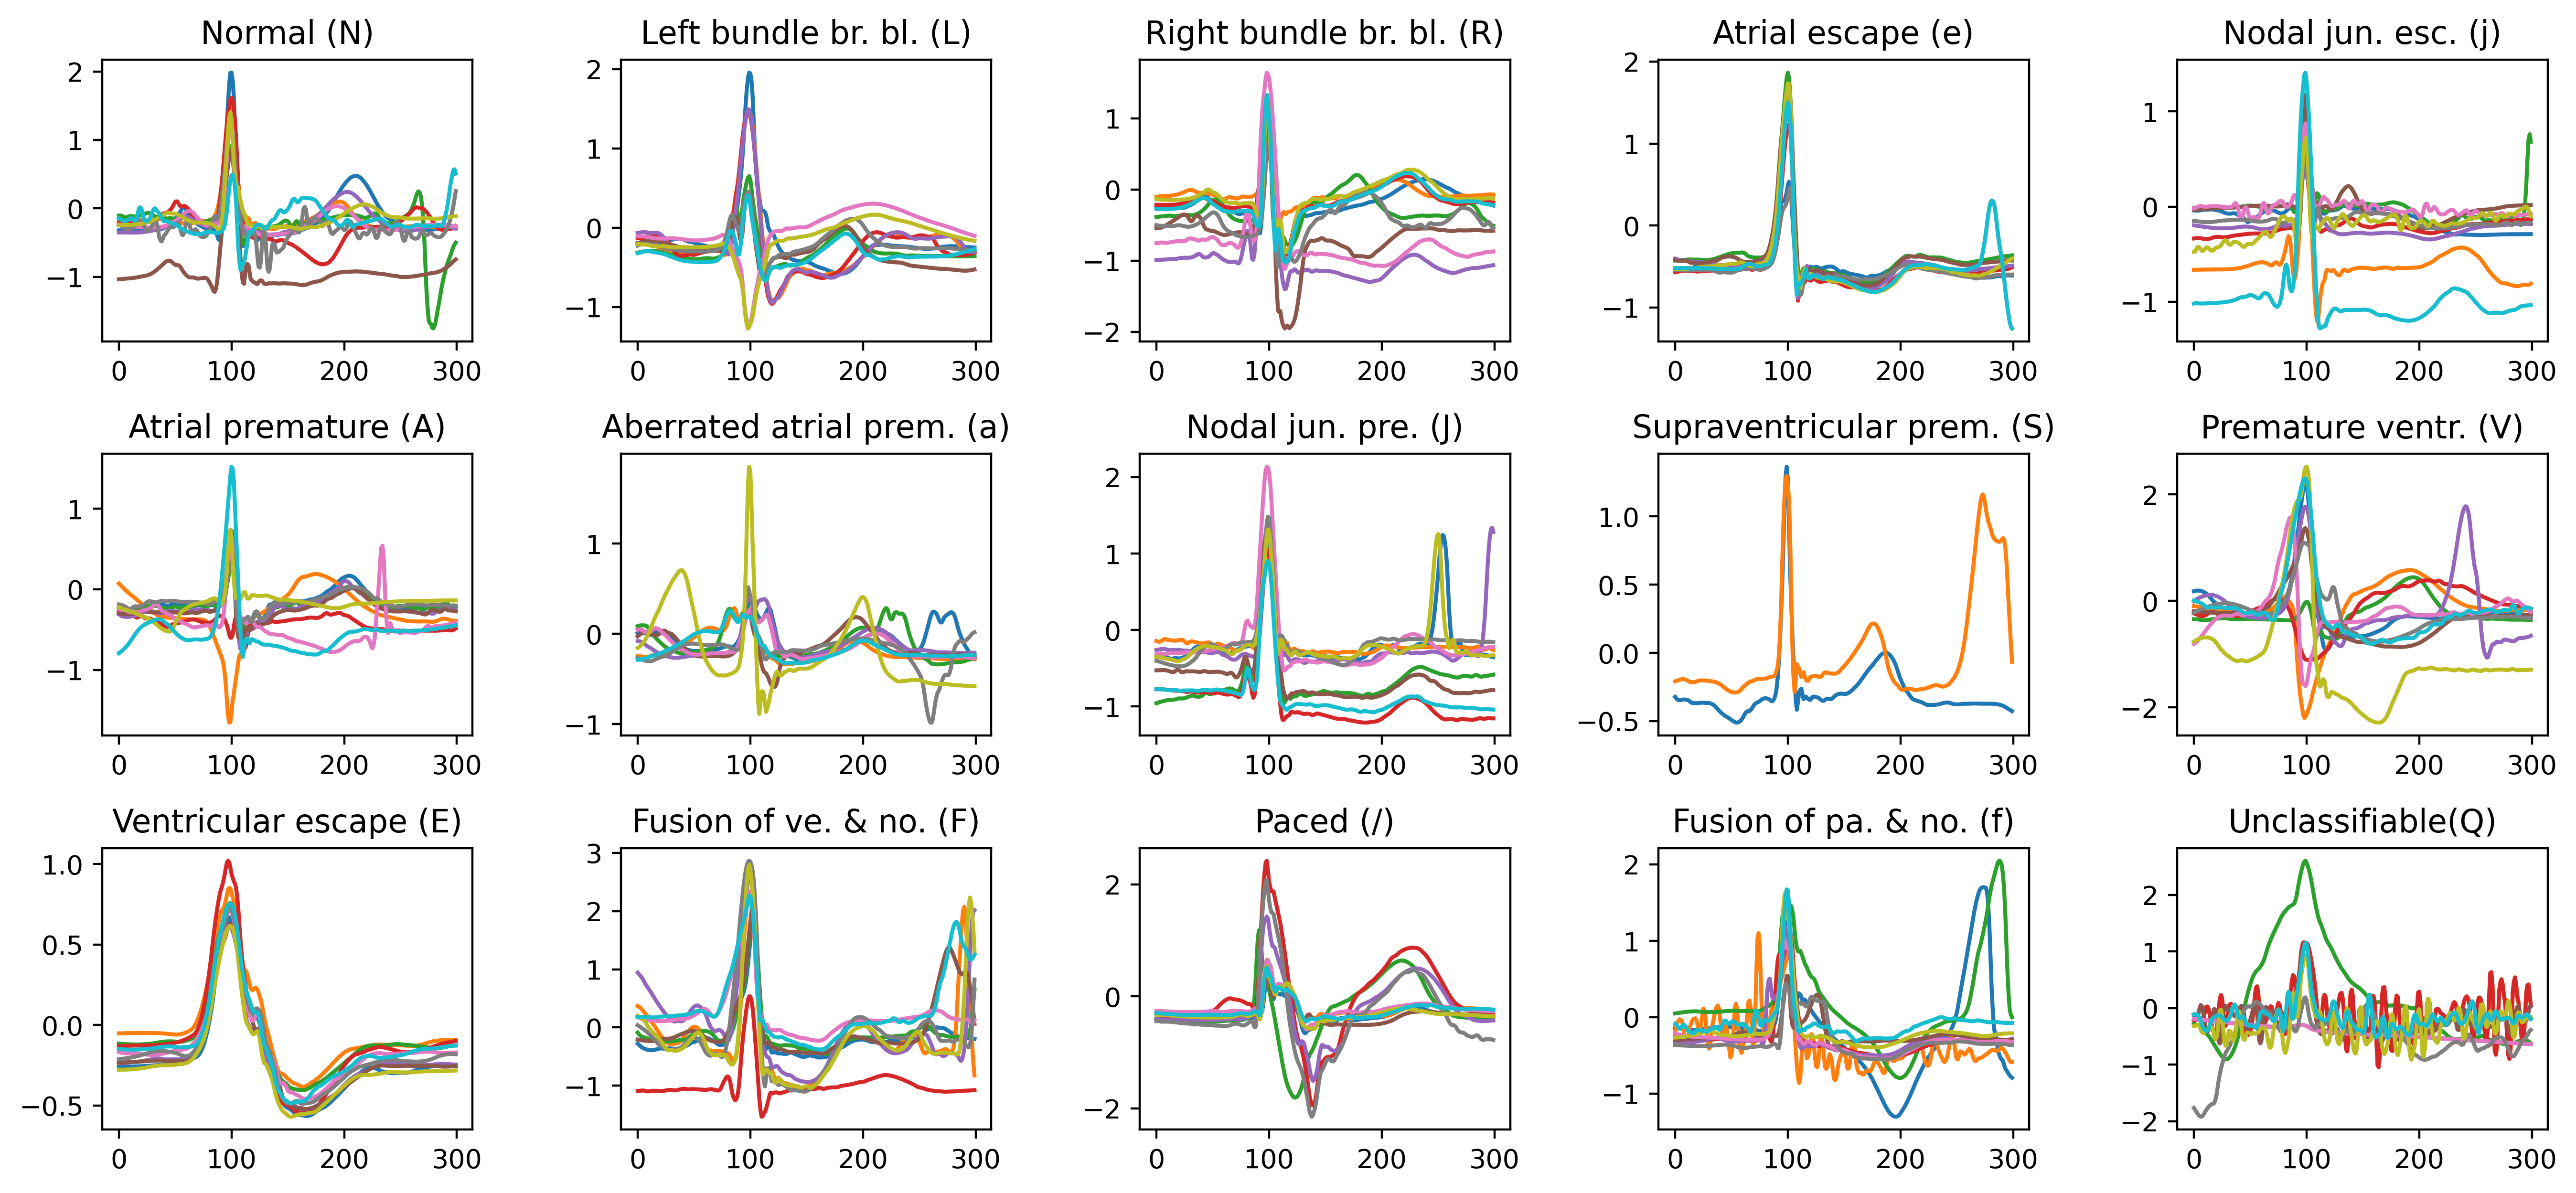

In [31]:
# Plotting 15 different types of heartbeat
fig = plt.figure(figsize=(16,7), dpi=400)
fig.tight_layout(pad=15.0)
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
  Plot_Random_Beat(type=i, num=10)
figure_path = 'ECG_Analysis/'
fig.savefig(figure_path+ 'all_heartbeats.png')

# **Part D: Train-Test Splitting and Class Balancing**

## **D1: Data loading**
Data is already loaded, **this step can be skipped.** However, here the whole dataset is saved in a train_ds variable.

### **a. Load whole data**

In [32]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', 
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', 
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', 
                 '222', '223', '228', '230', '231', '232', '233', '234']  # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)
    return train_ds

In [33]:
# Load the whole dataset (109305,301). Each row indicate an ECG beat time series data upto 300 
# and 301 colum is its label among 15 difference level
train_ds = loadData()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

In [34]:
Y = train_ds[:, 300]

In [35]:
# Here 15 class of ECG data are saved 
Y_list = list(Y)
Counter(Y_list)

Counter({0.0: 74920,
         1.0: 8063,
         2.0: 7244,
         9.0: 7123,
         12.0: 7012,
         5.0: 2540,
         13.0: 982,
         11.0: 802,
         4.0: 229,
         6.0: 150,
         10.0: 106,
         7.0: 83,
         14.0: 33,
         3.0: 16,
         8.0: 2})

### **b. 15 types to 5 level conversion**

In [36]:
# 15 level to 5 level conversion
Y_5class = np.copy(Y)

for i in range(Y.shape[0]):
  # print(i)
  if 0 <= Y[i] <= 4:
    Y_5class[i] = 0
  if 5 <= Y[i] <= 8:
    Y_5class[i] = 1
  if 9 <= Y[i] <= 10:
    Y_5class[i] = 2
  if Y[i] == 11:
    Y_5class[i] = 3
  if 12 <= Y[i] <= 14:
    Y_5class[i] = 4
print('changing done')

changing done


In [37]:
Y_5class_list = list(Y_5class)
Counter(Y_5class_list)

Counter({0.0: 90472, 4.0: 8027, 2.0: 7229, 1.0: 2775, 3.0: 802})

In [38]:
ecg_dataset = np.copy(train_ds)

In [39]:
# label encode the target variable # just convert numpy.float64 to numpy.int64

Y_5class = LabelEncoder().fit_transform(Y_5class)

In [40]:
ecg_data = ecg_dataset[:, :300]
ecg_lable = Y_5class.reshape(-1, 1) # otherwise np.hstack will not work 

In [41]:
# Complete ECG dataset with 5 type of Arrhythmia
ecg_dataset_5 = np.hstack((ecg_data, ecg_lable))

### **c. Per class data status checking (Full data)**

In [42]:
# Convert ndarray to dataframe
df_ecg = pd.DataFrame(ecg_dataset_5)
class_data = df_ecg[300].value_counts()
class_data

300
0.0    90472
4.0     8027
2.0     7229
1.0     2775
3.0      802
Name: count, dtype: int64

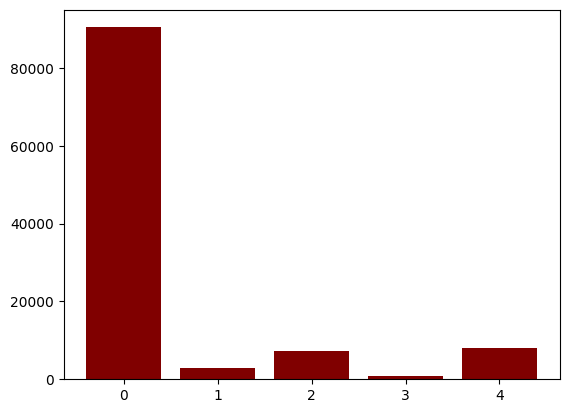

In [43]:
# per class data status plotting,
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

<Axes: xlabel='300'>

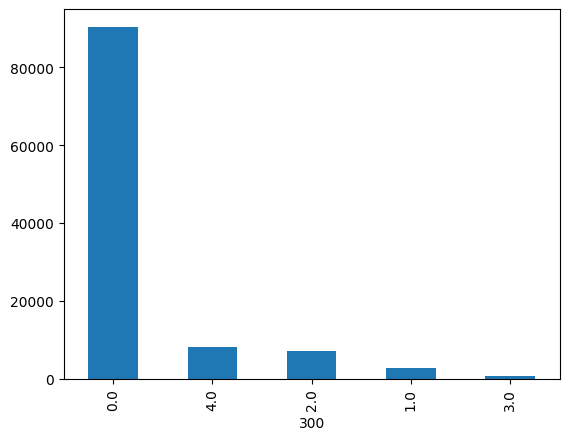

In [44]:
# shortcut for per class data status plotting,
# Order is not maintained by class. Higher to lower
df_ecg[300].value_counts().plot(kind='bar')

## **D2: Train-Test Spliting**
**Note: Class Balance should be done on Training Data Only. Not Testing Data.**

In [45]:
# train test splitting

ecg_data = ecg_dataset_5[:, :300]
ecg_label = ecg_dataset_5[:, 300]
x_train, x_test, y_train, y_test = train_test_split(ecg_data, ecg_label,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

In [46]:
# reshaping for using hstack function
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
train_data = np.hstack((x_train, y_train))
test_data = np.hstack((x_test, y_test))

In [47]:
#  converting dataframe
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [48]:
# saving the test data (in imbalanced condition)
file_name = project_path + 'test_data.pkl'
test_data.to_pickle(file_name)

**Training dataset status checking:** balanced / imbalanced

300
0.0    72396
4.0     6421
2.0     5773
1.0     2223
3.0      631
Name: count, dtype: int64


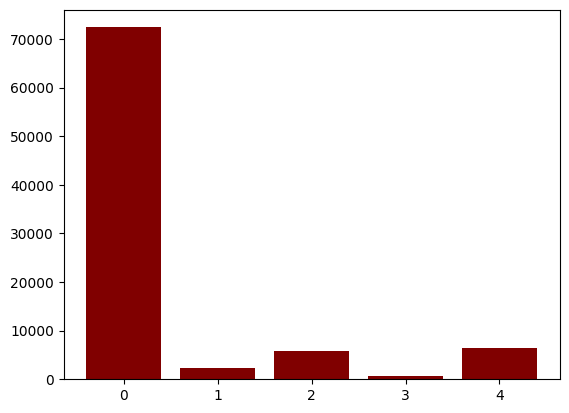

In [49]:
# Imblanced training data graph ploting 
class_data = train_data[300].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

## **D3: Class balancing by undersampling and SMOTE** 
**SMOTE** stands for '**Synthetic Minority Oversampling Technique**'.
Plan for train data
1. Class 1: Randomly selected 50000 data
2. Class 1, 2, 3, 4: Use SMOTE to oversample upto 50000 data

In [50]:
# extracting class 0 and 4 others class
train_data_0 = train_data.loc[(train_data[300] == 0)]
train_data_1234 = train_data.loc[(train_data[300] != 0)]

In [51]:
# 1. Class 1: Randomly selected 50000 data

train_data_0_resampled=train_data_0.sample(n=50000,random_state=42)

# convert dataframe to numpy array
train_data_0_resampled = train_data_0_resampled.to_numpy()

In [52]:
# 2. Class 1, 2, 3, 4: Use SMOTE to oversample upto 50000 data

# converting from df to np ndarray
train_data_1234_arr = train_data_1234.to_numpy()
X_4cl, y_4cl = train_data_1234_arr[:, :-1], train_data_1234_arr[:, -1]


# transform the dataset
strategy = {1:50000, 2:50000, 3:50000, 4:50000}
oversample = SMOTE(sampling_strategy=strategy)
X, y = oversample.fit_resample(X_4cl, y_4cl)

y = y.reshape(-1, 1)
train_data_1234_resampled = np.hstack((X, y))

In [53]:
# Join the class 0 and 1234
train_data_resampled = np.vstack((train_data_0_resampled, train_data_1234_resampled))

# shuffle the data, needed for proper training
np.take(train_data_resampled,np.random.permutation(train_data_resampled.shape[0]),axis=0,out=train_data_resampled)

array([[-0.28722445, -0.28848494, -0.28968116, ..., -0.2676001 ,
        -0.27120236,  0.        ],
       [-0.30751179, -0.3057489 , -0.30397116, ...,  0.75158413,
         0.82591842,  0.        ],
       [-0.16800687, -0.17244045, -0.17732933, ..., -0.28988055,
        -0.28821461,  1.        ],
       ...,
       [-0.07768788, -0.0759095 , -0.07457754, ..., -0.13804258,
        -0.13573806,  0.        ],
       [-0.65170895, -0.66662218, -0.68198135, ..., -0.11181153,
        -0.0988044 ,  2.        ],
       [ 0.0824179 ,  0.05861659,  0.0314233 , ...,  1.74909868,
         1.61083942,  2.        ]])

300
0.0    50000
1.0    50000
2.0    50000
3.0    50000
4.0    50000
Name: count, dtype: int64


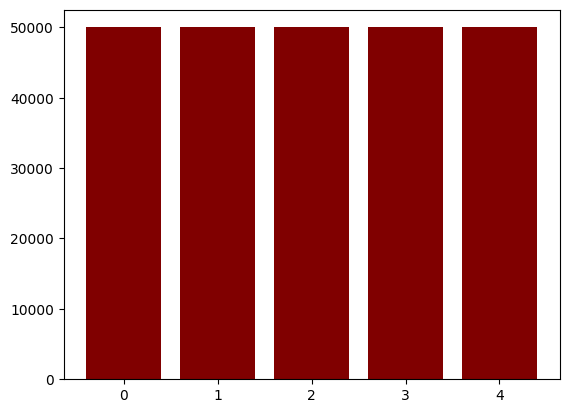

In [54]:
# blanced training data graph ploting 
train_data_r = pd.DataFrame(train_data_resampled)
class_data = train_data_r[300].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

# save balanced training data
file_name = project_path + 'train_data_SMOTE.pkl'
train_data_r.to_pickle(file_name)

In [55]:
data_bal = np.array(class_data)
data_bal2 = data_bal.reshape(1, 5)

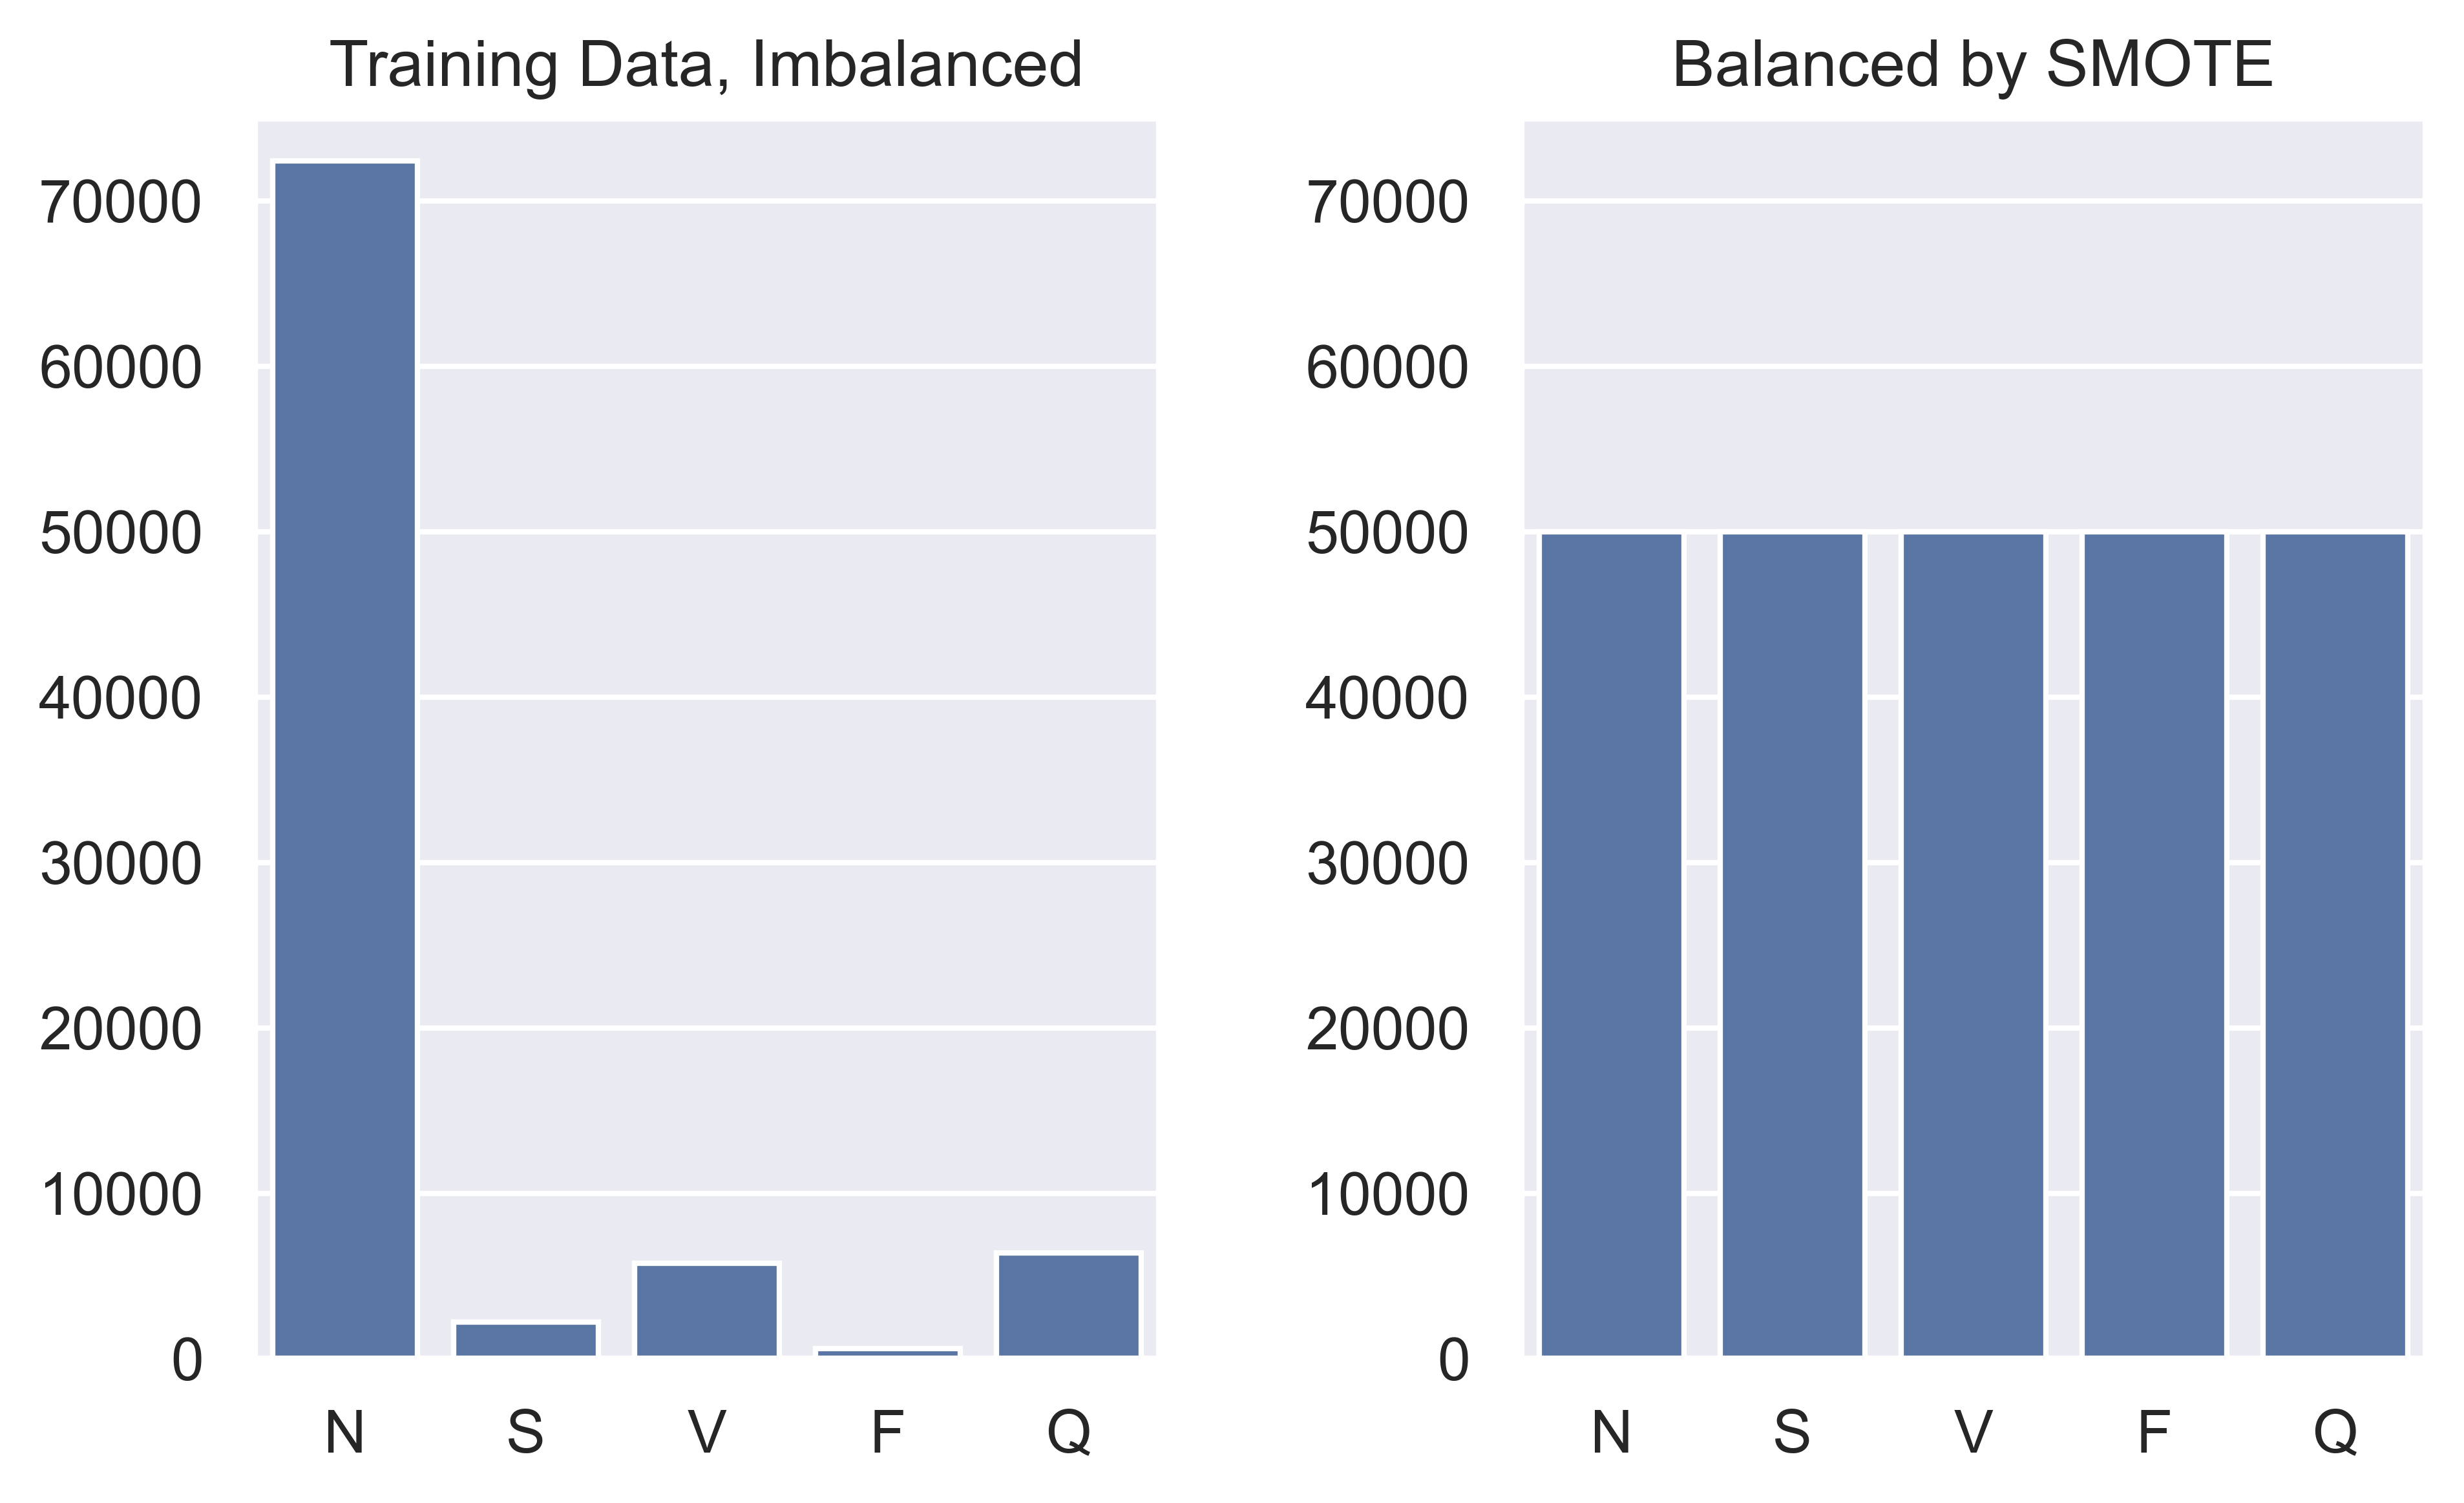

In [56]:
# a single plot which gives proper illustration before and after class balancing

sns.set()
sns.color_palette("hls", 8)

fig = plt.figure(figsize=(7,4), dpi=600)
plt.subplot(121)
sns.barplot(x = ['N', 'S', 'V', 'F', 'Q'], y = [72420, 2212, 5774, 637, 6401])
plt.ylim(0, 75000)
plt.title('Training Data, Imbalanced')

plt.subplot(122)
sns.barplot(x = ['N', 'S', 'V', 'F', 'Q'], y = class_data.values)
plt.ylim(0, 75000)
plt.title('Balanced by SMOTE')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.5)

figure_path = 'ECG_Analysis/'
fig.savefig(figure_path+ 'Class balancing.png')